#### Import Statements

In [106]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
import nltk.tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

In [98]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Sources
* https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/
* https://www.kaggle.com/code/sohamdas27/imdb-movie-review-eda-sentiment-analysis/notebook
* https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews
* https://colab.research.google.com/drive/1u00O59LZBtYjFS7Bb9dhDXpbCH4Bkob9?usp=sharing
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
* https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa



#### Load the IMDB Movie Reviews dataset from TensorFlow datasets and split into training and test sets

In [114]:
imdb, imdb_info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

#### Load the training and test sets into dataframes and combine the dataframes

In [9]:
train_df = tfds.as_dataframe(train_data, imdb_info)
test_df = tfds.as_dataframe(test_data, imdb_info)
combined_df = pd.concat([train_df, test_df])

In [10]:
combined_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [11]:
# Gets information about the dataframe.
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50000 non-null  int64 
 1   text    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [12]:
# Renames the columns.
combined_df.columns = ["sentiment", "review"]

In [13]:
# Gets the input data.
input_data = combined_df["review"]

#### Input Data Preprocessing

In [14]:
# Converts all reviews to lowercase letters.
input_data = input_data.str.decode("utf-8")
input_data = input_data.str.lower()
input_data.head()

0    this was an absolutely terrible movie. don't b...
1    i have been known to fall asleep during films,...
2    mann photographs the alberta rocky mountains i...
3    this is the kind of film for a snowy sunday af...
4    as others have mentioned, all the women that g...
Name: review, dtype: object

In [15]:
# Removes any HTML tags from the reviews.
def strip_html(review):
    soup = BeautifulSoup(review, "html.parser")
    return soup.get_text()

input_data = input_data.apply(strip_html)
input_data.head()

0    this was an absolutely terrible movie. don't b...
1    i have been known to fall asleep during films,...
2    mann photographs the alberta rocky mountains i...
3    this is the kind of film for a snowy sunday af...
4    as others have mentioned, all the women that g...
Name: review, dtype: object

In [16]:
# Removes any square brackets from the reviews.
def denoise_text(review):
    return re.sub('\[[^]]*\]', '', review)

input_data = input_data.apply(denoise_text)
input_data.head()

0    this was an absolutely terrible movie. don't b...
1    i have been known to fall asleep during films,...
2    mann photographs the alberta rocky mountains i...
3    this is the kind of film for a snowy sunday af...
4    as others have mentioned, all the women that g...
Name: review, dtype: object

In [17]:
# Removes special characters from the reviews.
def remove_special_characters(review):
    pattern = r'[^a-zA-z0-9\s]'
    return re.sub(pattern, '', review)

input_data = input_data.apply(remove_special_characters)
input_data.head()

0    this was an absolutely terrible movie dont be ...
1    i have been known to fall asleep during films ...
2    mann photographs the alberta rocky mountains i...
3    this is the kind of film for a snowy sunday af...
4    as others have mentioned all the women that go...
Name: review, dtype: object

In [18]:
# Breaks each review into a list of words.
def tokenize_reviews(review):
    return word_tokenize(review)

input_data = input_data.apply(tokenize_reviews)
input_data.head()

0    [this, was, an, absolutely, terrible, movie, d...
1    [i, have, been, known, to, fall, asleep, durin...
2    [mann, photographs, the, alberta, rocky, mount...
3    [this, is, the, kind, of, film, for, a, snowy,...
4    [as, others, have, mentioned, all, the, women,...
Name: review, dtype: object

In [19]:
# Removes irrelevant words e.g. "a", "the", "and".
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(review):
    return [w for w in review if not w in stop_words]
    
input_data = input_data.apply(remove_stop_words)
input_data.head()

0    [absolutely, terrible, movie, dont, lured, chr...
1    [known, fall, asleep, films, usually, due, com...
2    [mann, photographs, alberta, rocky, mountains,...
3    [kind, film, snowy, sunday, afternoon, rest, w...
4    [others, mentioned, women, go, nude, film, mos...
Name: review, dtype: object

In [20]:
# Applies stemming to each word in every review, meaning cutting down the word to its root form.
stemmer = PorterStemmer()

def stem_words(review):
    return [stemmer.stem(w) for w in review]

input_data = input_data.apply(stem_words)
input_data.head()

0    [absolut, terribl, movi, dont, lure, christoph...
1    [known, fall, asleep, film, usual, due, combin...
2    [mann, photograph, alberta, rocki, mountain, s...
3    [kind, film, snowi, sunday, afternoon, rest, w...
4    [other, mention, women, go, nude, film, mostli...
Name: review, dtype: object

In [21]:
# Applies lemmatization to the verbs in each review, meaning verbs are grouped based on their meaning.
lemmatizer = WordNetLemmatizer()

def lemmatize_verbs(review):
    return [lemmatizer.lemmatize(w, pos = wordnet.VERB) for w in review]

input_data = input_data.apply(lemmatize_verbs)
input_data.head()

0    [absolut, terribl, movi, dont, lure, christoph...
1    [know, fall, asleep, film, usual, due, combin,...
2    [mann, photograph, alberta, rocki, mountain, s...
3    [kind, film, snowi, sunday, afternoon, rest, w...
4    [other, mention, women, go, nude, film, mostli...
Name: review, dtype: object

In [22]:
# Applies lemmatization to the nouns in each review, meaning nouns are grouped based on their meaning.
def lemmatize_nouns(review):
    return [lemmatizer.lemmatize(w, pos = wordnet.NOUN) for w in review]

input_data = input_data.apply(lemmatize_nouns)
input_data.head()

0    [absolut, terribl, movi, dont, lure, christoph...
1    [know, fall, asleep, film, usual, due, combin,...
2    [mann, photograph, alberta, rocki, mountain, s...
3    [kind, film, snowi, sunday, afternoon, rest, w...
4    [other, mention, woman, go, nude, film, mostli...
Name: review, dtype: object

In [23]:
# Joins each review back into text.
def join_words(review):
    return " ".join(review)

input_data = input_data.apply(join_words)
input_data.head()

0    absolut terribl movi dont lure christoph walke...
1    know fall asleep film usual due combin thing i...
2    mann photograph alberta rocki mountain superb ...
3    kind film snowi sunday afternoon rest world go...
4    other mention woman go nude film mostli absolu...
Name: review, dtype: object

In [24]:
# Converts reviews into numeric vectors, where each review has its own vector.
# A vector has a TF-IDF score for every word in the entire collection of reviews.
# A higher score means that a word is more important/relevant.
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
bag_of_words = tfidf_vectorizer.fit_transform(input_data)
features = tfidf_vectorizer.get_feature_names()

In [25]:
# Stores numeric vectors in a dataframe.
X_bow = pd.DataFrame(bag_of_words.toarray(), columns=features)
X_bow.shape

(50000, 1000)

In [26]:
# Gets the preprocessed training and test sets. 
# The first 25,000 records were training data, and the last 25,000 records were test data from the combined dataset.
X_train = X_bow.iloc[0:25000]
Y_train = combined_df.iloc[0:25000, 0]
X_test = X_bow.iloc[25000:]
Y_test = combined_df.iloc[25000:, 0]

#### Model 1: Logistic Regression

In [22]:
# Trains a Logistic Regression model.
lr = LogisticRegression().fit(X_train, Y_train)

In [23]:
# List to store test accuracies for all models.
test_accuracies = []

# Gets the training accuracy.
print("Logistic Regression training accuracy:", round(lr.score(X_train, Y_train) * 100, 2))

# Gets the mean cross-validation accuracy.
cross_val_scores = cross_val_score(lr, X_train, Y_train)
print("Logistic Regression mean cross-validation accuracy:", round(cross_val_scores.mean() * 100, 2))

# Gets the test accuracy and adds it to the list.
lr_test_accuracy = round(lr.score(X_test, Y_test) * 100, 2)
test_accuracies.append(lr_test_accuracy)
print("Logistic Regression test accuracy:", lr_test_accuracy)

Logistic Regression training accuracy: 87.47
Logistic Regression mean cross-validation accuracy: 85.92
Logistic Regression test accuracy: 86.02


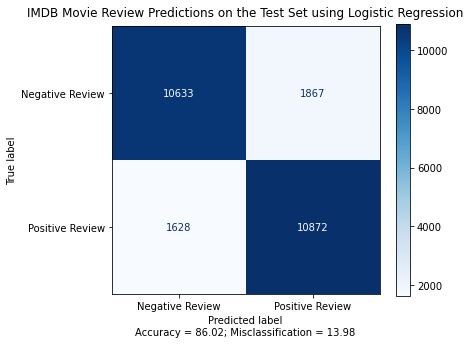

In [24]:
# Confusion matrix.
fig, ax = plt.subplots(figsize=(6,5))
disp = plot_confusion_matrix(lr, X_test, Y_test, xticks_rotation='horizontal', display_labels=['Negative Review', 'Positive Review'], cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title('IMDB Movie Review Predictions on the Test Set using Logistic Regression', pad=10)
plt.xlabel('Predicted label\nAccuracy = {:0.2f}; Misclassification = {:0.2f}'.format(lr_test_accuracy, 100 - lr_test_accuracy))
plt.show()

#### Model 2: KNN

In [25]:
# Trains a KNN model.
knn = KNeighborsClassifier().fit(X_train, Y_train)

In [26]:
# Gets the training accuracy.
print("KNN training accuracy:", round(knn.score(X_train, Y_train) * 100, 2))

# Gets the mean cross-validation accuracy.
cross_val_scores = cross_val_score(knn, X_train, Y_train)
print("KNN mean cross-validation accuracy:", round(cross_val_scores.mean() * 100, 2))

# Gets the test accuracy and adds it to the list.
knn_test_accuracy = round(knn.score(X_test, Y_test) * 100, 2)
test_accuracies.append(knn_test_accuracy)
print("KNN test accuracy:", knn_test_accuracy)

KNN training accuracy: 83.44
KNN mean cross-validation accuracy: 73.61
KNN test accuracy: 70.44


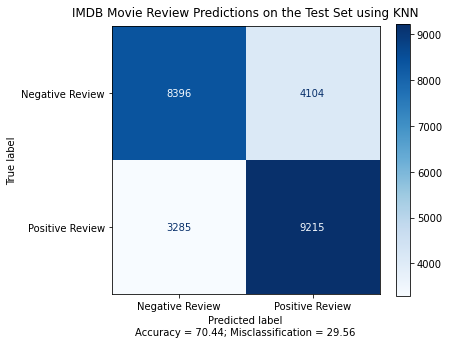

In [27]:
# Confusion matrix.
fig, ax = plt.subplots(figsize=(6,5))
disp = plot_confusion_matrix(knn, X_test, Y_test, xticks_rotation='horizontal', display_labels=['Negative Review', 'Positive Review'], cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title('IMDB Movie Review Predictions on the Test Set using KNN', pad=10)
plt.xlabel('Predicted label\nAccuracy = {:0.2f}; Misclassification = {:0.2f}'.format(knn_test_accuracy, 100 - knn_test_accuracy))
plt.show()

#### Model 3: MLP

In [28]:
# Trains a MLP model.
mlp = MLPClassifier().fit(X_train, Y_train)

In [29]:
# Gets the training accuracy.
print("MLP training accuracy:", round(mlp.score(X_train, Y_train) * 100, 2))

# Gets the mean cross-validation accuracy.
cross_val_scores = cross_val_score(mlp, X_train, Y_train)
print("MLP mean cross-validation accuracy:", round(cross_val_scores.mean() * 100, 2))

# Gets the test accuracy and adds it to a list.
mlp_test_accuracy = round(mlp.score(X_test, Y_test) * 100, 2)
test_accuracies.append(mlp_test_accuracy)
print("MLP test accuracy:", mlp_test_accuracy)

MLP training accuracy: 100.0
MLP mean cross-validation accuracy: 84.7
MLP test accuracy: 84.95


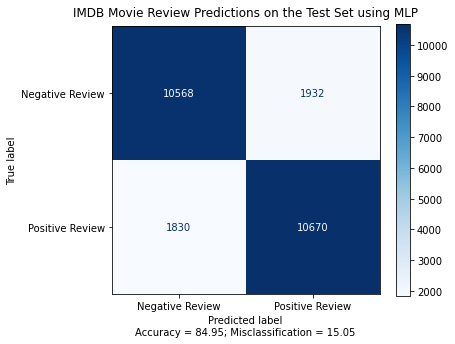

In [30]:
# Confusion matrix.
fig, ax = plt.subplots(figsize=(6,5))
disp = plot_confusion_matrix(mlp, X_test, Y_test, xticks_rotation='horizontal', display_labels=['Negative Review', 'Positive Review'], cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title('IMDB Movie Review Predictions on the Test Set using MLP', pad=10)
plt.xlabel('Predicted label\nAccuracy = {:0.2f}; Misclassification = {:0.2f}'.format(mlp_test_accuracy, 100 - mlp_test_accuracy))
plt.show()

#### Model 4: Random Forest

In [31]:
# Trains a Random Forest model.
rf = RandomForestClassifier().fit(X_train, Y_train)

In [32]:
# Gets the training accuracy.
print("Random Forest training accuracy:", round(rf.score(X_train, Y_train) * 100, 2))

# Gets the mean cross-validation accuracy.
cross_val_scores = cross_val_score(rf, X_train, Y_train)
print("Random Forest mean cross-validation accuracy:", round(cross_val_scores.mean() * 100, 2))

# Gets the test accuracy and adds it to a list.
rf_test_accuracy = round(rf.score(X_test, Y_test) * 100, 2)
test_accuracies.append(rf_test_accuracy)
print("Random Forest test accuracy:", rf_test_accuracy)

Random Forest training accuracy: 100.0
Random Forest mean cross-validation accuracy: 82.65
Random Forest test accuracy: 83.07


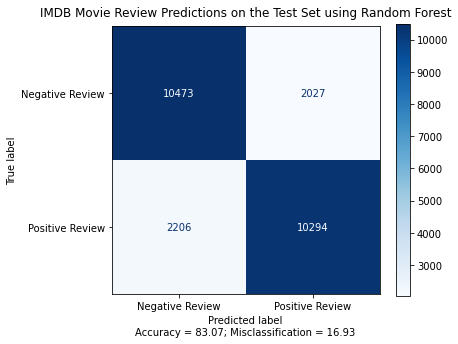

In [37]:
# Confusion matrix.
fig, ax = plt.subplots(figsize=(6,5))
disp = plot_confusion_matrix(rf, X_test, Y_test, xticks_rotation='horizontal', display_labels=['Negative Review', 'Positive Review'], cmap=plt.cm.Blues, normalize=None, ax=ax, values_format = '')
disp.ax_.set_title('IMDB Movie Review Predictions on the Test Set using Random Forest', pad=10)
plt.xlabel('Predicted label\nAccuracy = {:0.2f}; Misclassification = {:0.2f}'.format(rf_test_accuracy, 100 - rf_test_accuracy))
plt.show()

#### Model 5: Ensemble Learning

In [34]:
# Trains an Ensemble Learning using a Stacking Classifier combining all my previous models.
estimators = [('lr', lr), ('knn', knn), ('mlp', mlp), ('rf', rf)]
ensemble = StackingClassifier(estimators=estimators).fit(X_train, Y_train)

In [35]:
# Gets the training accuracy.
print("Ensemble Learning training accuracy:", round(ensemble.score(X_train, Y_train) * 100, 2))

# Gets the mean cross-validation accuracy.
cross_val_scores = cross_val_score(ensemble, X_train, Y_train)
print("Ensemble Learning mean cross-validation accuracy:", round(cross_val_scores.mean() * 100, 2))

# Gets the test accuracy and adds it to a list.
ensemble_test_accuracy = round(ensemble.score(X_test, Y_test) * 100, 2)
test_accuracies.append(ensemble_test_accuracy)
print("Ensemble Learning test accuracy:", ensemble_test_accuracy)

Ensemble Learning training accuracy: 95.86
Ensemble Learning mean cross-validation accuracy: 86.3
Ensemble Learning test accuracy: 86.28


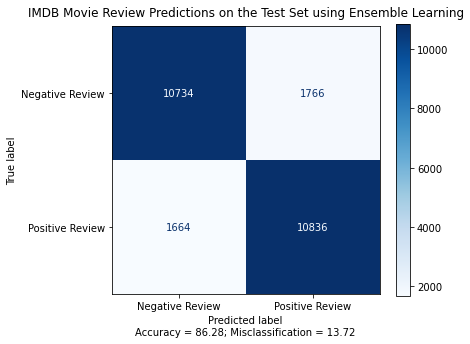

In [36]:
# Confusion matrix.
fig, ax = plt.subplots(figsize=(6,5))
disp = plot_confusion_matrix(ensemble, X_test, Y_test, xticks_rotation='horizontal', display_labels=['Negative Review', 'Positive Review'], cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title('IMDB Movie Review Predictions on the Test Set using Ensemble Learning', pad=10)
plt.xlabel('Predicted label\nAccuracy = {:0.2f}; Misclassification = {:0.2f}'.format(ensemble_test_accuracy, 100 - ensemble_test_accuracy))
plt.show()

#### Plot test accuracies from all the models

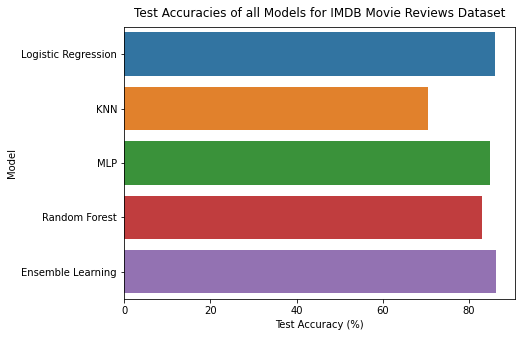

In [40]:
# List of all models.
models = ['Logistic Regression', 'KNN', 'MLP', 'Random Forest', 'Ensemble Learning']

# Creates a dataframe to store the models and their corresponding test accuracies.
accuracies_df = pd.DataFrame({'Model': models, 'Test Accuracy': test_accuracies})

# Bar graph of the models and their test accuracies.
plt.figure(figsize=(7,5))
sns.barplot(
    data=accuracies_df,
    x='Test Accuracy',
    y='Model')
plt.title("Test Accuracies of all Models for IMDB Movie Reviews Dataset", pad=10)
plt.xlabel("Test Accuracy (%)");